<a href="https://colab.research.google.com/github/netaamz/DL-Model-for-Automated-Detection-of-Meniscus-Tears-in-Knee-MRI-Images/blob/main/3_planes_DenseNet__transfer_learning_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone: Development of an algorithm for automatic detection of meniscus tears in radiographic images of the knee.

In [1]:
import warnings
warnings.filterwarnings("ignore")

#!pip install pyyaml

In [2]:

!pip install tensorflow
!pip install keras
!pip install h5py
!pip install sklearn
!pip install opencv-python
!pip install seaborn
!pip install matplotlib
!pip install numpy

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


### Contents:
- [Background](#Background)
- [Data](#Data)
- [Building own models](#Building-own-models)
- [Evaluate results](#Evaluate-results)



In [3]:
# Import libraries here
import os
import tempfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from glob import glob
from IPython.display import Image, display
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, accuracy_score

import random as random
import imageio
import imgaug as ia
import tensorflow as tf
from tensorflow import keras
pd.options.mode.chained_assignment = None  # default='warn'


**Data from [MRNet](https://stanfordmlgroup.github.io/competitions/mrnet/):**
* Images of 1370 knee MRI exams performed at Stanford University Medical Center. The dataset contains 1,104 (80.6%) abnormal exams,  with 319 (23.3%) ACL tears and 508 (37.1%) meniscal tears; labels were obtained through manual extraction from clinical reports.
* train set: consists of 1130 MRI images from coronal, sagittal and transverse planes
* validation set: consists of 120 MRI images from coronal, sagittal and transverse planes


## Data import

**import data and get labels**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
train_path = '/content/drive/My Drive/miniscus data set/MRNet-v1.0/train'
valid_path = '/content/drive/My Drive/miniscus data set/MRNet-v1.0/valid'

In [6]:
datasets = {'train': train_path, 'valid': valid_path}
planes = ['coronal', 'sagittal', 'axial']
diagnosis = ['meniscus']

In [ ]:
def get_data(dataset_type, plane, diagnosis):
    '''this function gets the data from the original dataset'''
    # for eg, (train, sagittal, acl)
    if dataset_type == 'train':
        go = train_path
    else:
        go = valid_path

#     img_path = glob(f'{go}/{plane}/*.npy')
    plane_dir = f'{go}/{plane}'
    data = os.listdir(plane_dir)

    label_path = f'/content/drive/My Drive/miniscus data set/MRNet-v1.0/{dataset_type}-{diagnosis}.csv'
    label_df = pd.read_csv(label_path, names=['nr', diagnosis])
    label_data = list(label_df[diagnosis])

    return(data, plane_dir, label_data)

**meniscus dataset**

In [ ]:
# training data
train_coronal_data, train_coronal_dir, train_men_label = get_data('train', 'coronal', 'meniscus')
train_axial_data, train_axial_dir, train_men_label = get_data('train', 'axial', 'meniscus')
train_sagittal_data, train_sagittal_dir, train_men_label = get_data('train', 'sagittal', 'meniscus')

In [ ]:
# validation data
valid_coronal_data, valid_coronal_dir, valid_men_label = get_data('valid','coronal','meniscus')
valid_axial_data, valid_axial_dir, valid_men_label = get_data('valid','axial','meniscus')
valid_sagittal_data, valid_sagittal_dir, valid_men_label = get_data('valid','sagittal','meniscus')

In [ ]:
train_sagittal_data[0]

'0048.npy'

In [ ]:
train_sagittal_dir

'/content/drive/My Drive/miniscus data set/MRNet-v1.0/train/sagittal'

The dataset contains *s* x 256 x 256 images. Since middle images are the most useful, only 3 middle slides in the series are retained.


## **data generation for meniscus**

In [8]:
def data_gen(dataset_type, plane, diagnosis):
    '''this function gets the data from the extracted datset'''
    # for eg, (train, sagittal, mensicus)
    if dataset_type == 'train':
        go = '/content/drive/My Drive/miniscus data set/MRNet-v1.0/train_transformf' # if we want without filter then:  /content/drive/My Drive/miniscus data set/MRNet-v1.0/train_transform
    else:
        go = '/content/drive/My Drive/miniscus data set/MRNet-v1.0/valid_transformf' # if we want without filter then: /content/drive/My Drive/miniscus data set/MRNet-v1.0/valid_transform

    plane_dir = f'{go}/{plane}.npy'

    data = np.load(plane_dir)
    label_path = f'/content/drive/My Drive/miniscus data set/MRNet-v1.0/{dataset_type}-{diagnosis}.csv'
#     label_path = f'data/{dataset_type}-{diagnosis}.csv'
    label_df = pd.read_csv(label_path, names=['nr', diagnosis])
    label_data = list(label_df[diagnosis])

    return(data, label_data)


Note that training data for all planes are the same. Only labels are different.

In [9]:
# generate training input
coronal_mensicus, coronal_mensicus_label = data_gen('train', 'coronal/extracted_images', 'meniscus')
axial_mensicus, axial_mensicus_label = data_gen('train', 'axial/extracted_images', 'meniscus')
sagittal_mensicus, sagittal_mensicus_label = data_gen('train', 'sagittal/extracted_images', 'meniscus')
print(sagittal_mensicus.shape)
# generate validation
coronal_mensicus_val, coronal_mensicus_label_val  = data_gen('valid', 'coronal/extracted_images', 'meniscus')
axial_mensicus_val, axial_mensicus_label_val  = data_gen('valid', 'axial/extracted_images', 'meniscus')
sagittal_mensicus_val, sagittal_mensicus_label_val  = data_gen('valid', 'sagittal/extracted_images', 'meniscus')

(1130, 256, 256, 3)


In [ ]:
sagittal_mensicus_val.view

<function ndarray.view>

In [10]:
from keras.utils import to_categorical  # Import to_categorical
base_path = "/content/drive/My Drive/miniscus data set/MRNet-v1.0/"

num_classes =2

sagittal_mensicus_label = to_categorical(sagittal_mensicus_label, num_classes)
sagittal_mensicus_label_val = to_categorical(sagittal_mensicus_label_val, num_classes)

coronal_mensicus_label = to_categorical(coronal_mensicus_label, num_classes)
coronal_mensicus_label_val = to_categorical(coronal_mensicus_label_val, num_classes)

axial_mensicus_label = to_categorical(axial_mensicus_label, num_classes)
axial_mensicus_label_val = to_categorical(axial_mensicus_label_val, num_classes)


#  Hyperparameters

In [11]:

from sklearn.metrics import log_loss
import numpy as np
import os
import keras
import random
import cv2
import math
import seaborn as sns

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

# Transfer Learning

In [12]:
    # Define your parameters
    img_rows, img_cols = 256, 256  # Adjust based on your actual image dimensions
    channel = 3  # Assuming grayscale images
    num_classes = 2  # Binary classification
    batch_size = 32
    nb_epoch = 100
    dropout = 0.4
    lr = 5e-4  # Learning rat

In [36]:
import tensorflow as tf
import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Lambda, BatchNormalization
from tensorflow.keras.optimizers import SGD, schedules
from tensorflow.keras.callbacks import ModelCheckpoint
  # Define your parameters

def create_model1(input_shape, num_classes, dropout):
    # Load the pre-trained DenseNet121 model
    # Change the input shape to (256, 256, 3)
    base_model = DenseNet121(weights='imagenet', include_top=False, pooling=None,input_shape=input_shape)

    # Create an input layer for grayscale images
    input_tensor = Input(shape=input_shape)

    x = base_model(input_tensor)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)  # Add Batch Normalization
    x = tf.keras.layers.Dropout(dropout)(x)
    x = Dense(1024, activation='relu')(x)
    output = Dense(num_classes, activation='sigmoid')(x)
    # Create the final model
    model = Model(inputs=input_tensor, outputs=output)

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    return model

if __name__ == '__main__':
    # Create the model
    input_shape = (img_rows, img_cols, channel)
    model = create_model1(input_shape, num_classes, dropout)

    # Compile the model
    model.compile(optimizer=SGD(learning_rate=lr, momentum=0.9),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Set up the checkpoint
    filepath = "bestmodel.keras"
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]


    # Train the model - axial
    history_axial = model.fit(axial_mensicus, axial_mensicus_label,
                        batch_size=batch_size,
                        epochs=nb_epoch,
                        shuffle=True,
                        verbose=1,
                        validation_data=(axial_mensicus_val, axial_mensicus_label_val),
                        callbacks=callbacks_list)

    # Train the model - coronal
    history_coronal = model.fit(coronal_mensicus, coronal_mensicus_label,
                        batch_size=batch_size,
                        epochs=nb_epoch,
                        shuffle=True,
                        verbose=1,
                        validation_data=(coronal_mensicus_val, coronal_mensicus_label_val),
                        callbacks=callbacks_list)

    # Train the model- sagittal
    history_sagittal = model.fit(sagittal_mensicus, sagittal_mensicus_label,
                        batch_size=batch_size,
                        epochs=nb_epoch,
                        shuffle=True,
                        verbose=1,
                        validation_data=(sagittal_mensicus_val, sagittal_mensicus_label_val),
                        callbacks=callbacks_list)

    # Make predictions for each plane
    predictions_valid_axial = model.predict(axial_mensicus_val, batch_size=batch_size, verbose=1)

    predictions_valid_coronal = model.predict(coronal_mensicus_val, batch_size=batch_size, verbose=1)

    predictions_valid_sagittal = model.predict(sagittal_mensicus_val, batch_size=batch_size, verbose=1)

    from sklearn.metrics import log_loss

    score_axial = log_loss(axial_mensicus_label_val, predictions_valid_axial)
    score_coronal = log_loss(coronal_mensicus_label_val, predictions_valid_coronal)
    score_sagittal = log_loss(sagittal_mensicus_label_val, predictions_valid_sagittal)

    print(f"Log Loss: {score_axial}")
    print(f"Log Loss: {score_coronal}")
    print(f"Log Loss: {score_sagittal}")

    model.summary()

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.4289 - loss: 0.8479
Epoch 1: val_accuracy improved from -inf to 0.56667, saving model to bestmodel.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 59s 874ms/step - accuracy: 0.4313 - loss: 0.8458 - val_accuracy: 0.5667 - val_loss: 0.9272
Epoch 2/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.6659 - loss: 0.6712
Epoch 2: val_accuracy did not improve from 0.56667
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.6642 - loss: 0.6728 - val_accuracy: 0.5667 - val_loss: 0.7822
Epoch 3/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.6407 - loss: 0.6686
Epoch 3: val_accuracy did not improve from 0.56667
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.6397 - loss: 0.6696 - val_accuracy: 0.5667 - val_loss: 0.7745
Epoch 4/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.6363 - loss: 0.6720
Epoch 4: val_accuracy did not improve from 0.56667
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.6363 - loss: 

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)          │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet121 (Functional)             │ (None, 8, 8, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_41          │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 2)                   │           2,050 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,146,950 (34.89 MB)

 Trainable params: 1,053,698 (4.02 MB)

 Non-trainable params: 7,039,552 (26.85 MB)

 Optimizer params: 1,053,700 (4.02 MB)

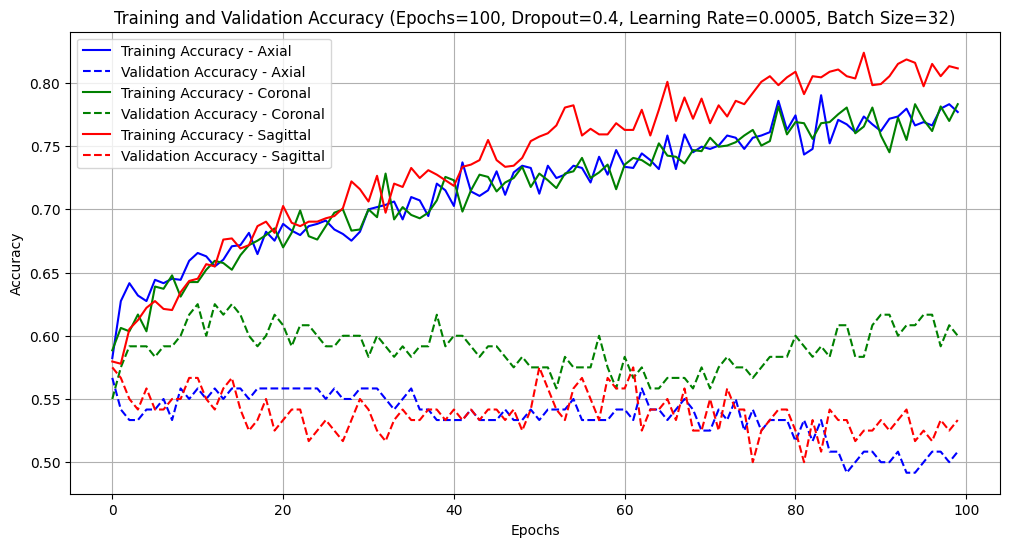

<Figure size 640x480 with 0 Axes>

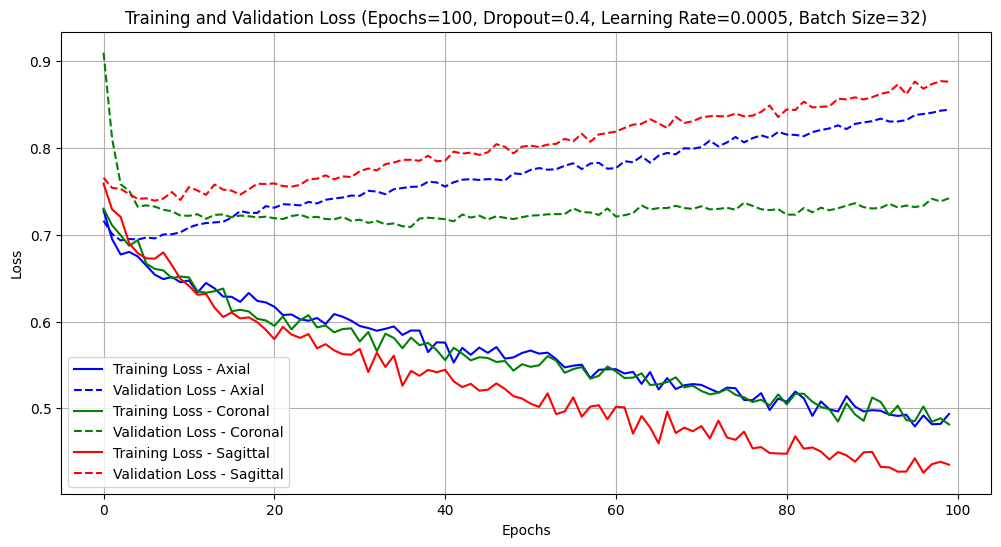

In [ ]:
# Evaluating Accuracy and Loss for the three planes: axial, coronal, and sagittal
%matplotlib inline
import matplotlib.pyplot as plt

# Axial metrics
acc_axial = history_axial.history['accuracy']
val_acc_axial = history_axial.history['val_accuracy']
loss_axial = history_axial.history['loss']
val_loss_axial = history_axial.history['val_loss']

# Coronal metrics
acc_coronal = history_coronal.history['accuracy']
val_acc_coronal = history_coronal.history['val_accuracy']
loss_coronal = history_coronal.history['loss']
val_loss_coronal = history_coronal.history['val_loss']

# Sagittal metrics
acc_sagittal = history_sagittal.history['accuracy']
val_acc_sagittal = history_sagittal.history['val_accuracy']
loss_sagittal = history_sagittal.history['loss']
val_loss_sagittal = history_sagittal.history['val_loss']

# Plot training and validation accuracy for each plane
plt.figure(figsize=(12, 6))
plt.plot(epochs, acc_axial, 'b', label='Training Accuracy - Axial')
plt.plot(epochs, val_acc_axial, 'b--', label='Validation Accuracy - Axial')
plt.plot(epochs, acc_coronal, 'g', label='Training Accuracy - Coronal')
plt.plot(epochs, val_acc_coronal, 'g--', label='Validation Accuracy - Coronal')
plt.plot(epochs, acc_sagittal, 'r', label='Training Accuracy - Sagittal')
plt.plot(epochs, val_acc_sagittal, 'r--', label='Validation Accuracy - Sagittal')

plt.title(f'Training and Validation Accuracy (Epochs={nb_epoch}, Dropout={dropout}, Learning Rate={lr}, Batch Size={batch_size})')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig(f'Train_val_acc_all_planes_Ep={nb_epoch}_Do={dropout}_Lr={lr}_Bs={batch_size}.png')

plt.figure()

# Plot training and validation loss for each plane
plt.figure(figsize=(12, 6))
plt.plot(epochs, loss_axial, 'b', label='Training Loss - Axial')
plt.plot(epochs, val_loss_axial, 'b--', label='Validation Loss - Axial')
plt.plot(epochs, loss_coronal, 'g', label='Training Loss - Coronal')
plt.plot(epochs, val_loss_coronal, 'g--', label='Validation Loss - Coronal')
plt.plot(epochs, loss_sagittal, 'r', label='Training Loss - Sagittal')
plt.plot(epochs, val_loss_sagittal, 'r--', label='Validation Loss - Sagittal')

plt.title(f'Training and Validation Loss (Epochs={nb_epoch}, Dropout={dropout}, Learning Rate={lr}, Batch Size={batch_size})')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(f'Train_val_loss_all_planes_Ep={nb_epoch}_Do={dropout}_Lr={lr}_Bs={batch_size}.png')

plt.show()


In [34]:
# Function to calculate accuracy and misclassification
def calculate_accuracy(ypred, ytest):
    total = 0
    accurate = 0
    accurateindex = []
    wrongindex = []

    for i in range(len(ypred)):
        if np.argmax(ypred[i]) == np.argmax(ytest[i]):
            accurate += 1
            accurateindex.append(i)
        else:
            wrongindex.append(i)
        total += 1

    accuracy = round(accurate / total * 100, 3)
    return total, accurate, total - accurate, accuracy, accurateindex, wrongindex

In [37]:
# Predictions for each plane
ypred_axial = model.predict(axial_mensicus_val)
ypred_coronal = model.predict(coronal_mensicus_val)
ypred_sagittal = model.predict(sagittal_mensicus_val)



# Axial plane accuracy
total_axial, accurate_axial, wrong_axial, accuracy_axial, accurateindex_axial, wrongindex_axial = calculate_accuracy(ypred_axial, axial_mensicus_label_val)
print('Axial - Total test data:', total_axial, '\tAccurately predicted data:', accurate_axial, '\tWrongly predicted data:', wrong_axial)
print('Axial Accuracy:', accuracy_axial, '%')

# Coronal plane accuracy
total_coronal, accurate_coronal, wrong_coronal, accuracy_coronal, accurateindex_coronal, wrongindex_coronal = calculate_accuracy(ypred_coronal, coronal_mensicus_label_val)
print('Coronal - Total test data:', total_coronal, '\tAccurately predicted data:', accurate_coronal, '\tWrongly predicted data:', wrong_coronal)
print('Coronal Accuracy:', accuracy_coronal, '%')

# Sagittal plane accuracy
total_sagittal, accurate_sagittal, wrong_sagittal, accuracy_sagittal, accurateindex_sagittal, wrongindex_sagittal = calculate_accuracy(ypred_sagittal, sagittal_mensicus_label_val)
print('Sagittal - Total test data:', total_sagittal, '\tAccurately predicted data:', accurate_sagittal, '\tWrongly predicted data:', wrong_sagittal)
print('Sagittal Accuracy:', accuracy_sagittal, '%')


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Axial - Total test data: 120 	Accurately predicted data: 64 	Wrongly predicted data: 56
Axial Accuracy: 53.333 %
Coronal - Total test data: 120 	Accurately predicted data: 77 	Wrongly predicted data: 43
Coronal Accuracy: 64.167 %
Sagittal - Total test data: 120 	Accurately predicted data: 68 	Wrongly predicted data: 52
Sagittal Accuracy: 56.667 %
